# K-Means Clustering을 활용한 작품 분류

## 0. 라이브러리

In [1]:
import os
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shutil
import pickle
from tqdm import tqdm
from colorsys import rgb_to_hsv
from keras.preprocessing.image import load_img

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from PIL import Image

from numpy import dot
from numpy.linalg import norm

## 1. 클러스터 데이터 로드

In [2]:
def load_clu_data(path, sample_ratio = 1):
    clu_data = []

    with os.scandir(path) as files:
        for file in files:
            if file.name.endswith('npy'):
                clu_data.append(np.load(file))
    if sample_ratio < 1:
        clu_data = random.sample(clu_data, int(len(clu_data) * sample_ratio))
        
    return np.array(clu_data)

## 2. 데이터 평면화 작업

In [3]:
def flatten_clusters_rgb(clu_data, div = 5):
    flt_data = []
    for feature in clu_data: 
        R = ((feature[:,0] / 256) * div).astype(int)
        G = ((feature[:,1] / 256) * div).astype(int)
        B = ((feature[:,2] / 256) * div).astype(int)
        tar = G * div * div + R * div + B
        new_row = np.zeros(div ** 3)
        for num, val in zip(tar, feature[:, -1]):
            new_row[num] += val
        flt_data.append(new_row)
    return np.array(flt_data)

## 3. 차원 축소

In [4]:
def reduction_feature_pca(flt_data, threshold = 0.99):
    pca = PCA(n_components = len(flt_data[0]), random_state = 2021)
    pca.fit_transform(flt_data)
    
    ratio = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(ratio >= threshold) + 1
    
    pca = PCA(n_components = d, random_state = 2021)
    return pca.fit_transform(flt_data)

## 4. 작품 클러스터링 및 그룹화

### 4-1. load file names

In [5]:
def get_file_names(path, ends, sample_ratio = 1):
    file_names = []

    with os.scandir(path) as files:
        for file in files:
            # .jpg .png 등 확장자명이 'g'로 끝나는 파일들 모두 읽기
            if file.name.endswith(ends):
                file_names.append(path + file.name)

    if sample_ratio < 1:
        file_names = random.sample(file_names, int(len(file_names) * sample_ratio))
        
    return file_names

### 4-2. Labels

In [6]:
def get_clu_labels(data, cluster = 25, state = 2021):
    km = KMeans(n_clusters = cluster, random_state = state)
    km.fit(data)
    return km.labels_

### 4-3. Visualization with groups

In [7]:
def show_img_by_group(img_path, labels, group_num, grid = (7, 3), img_size = (360, 360)):
    plt.figure(figsize = (grid[0] * 3, grid[1] * 3))
    group = []
    for path, label in zip(img_path, labels):
        if label == group_num:
            group.append(path)
    
    print(f"Cluster size : {len(group)}")
    for idx in range(min(grid[1] * grid[0], len(group))):
        
        plt.subplot(grid[1], grid[0] ,idx+1);
        img = load_img(group[idx], target_size = img_size)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

## 5. 작품 저장

In [8]:
def save_groups(path, img_path, labels):
    for img, label in zip(img_path, labels):
        result_path = path + str(label) + "/"
        try:
            if not os.path.exists(result_path):
                os.makedirs(result_path)
        except OSError:
            print ('Error: Creating directory. ' +  result_path)   
        shutil.copyfile(img, result_path + img.rsplit('/')[1])

## 1~5. Clustering Images

In [9]:
def clustering_images_v1(save_dir, img_dir, result_dir, clu):
    clu_data = load_clu_data(save_dir)
    flt_data = flatten_clusters_rgb(clu_data)
    pca_data = reduction_feature_pca(flt_data)
    img_names = get_file_names(img_dir, 'jpg')
    data_labels = get_clu_labels(pca_data, cluster = clu)
    save_groups(result_dir, img_names, data_labels)

## Example

In [10]:
clu_data = load_clu_data('saves_HSV25/')
clu_data[0][0]

array([7.59073129e+01, 7.74370748e+01, 6.99237528e+01, 2.17805839e+02,
       1.95519274e+02, 1.41979104e+02, 5.71761661e+01, 2.72222222e-02])

In [11]:
flt_data = flatten_clusters_rgb(clu_data)
flt_data[0][0:10]

array([0.41635802, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [12]:
pca_data = reduction_feature_pca(flt_data)
pca_data[0][0:10]

array([-0.11821044,  0.1772578 ,  0.27548663, -0.07103565, -0.04461532,
        0.04231078,  0.01493826,  0.09070491,  0.00160073, -0.04681313])

In [14]:
img_names = get_file_names('images/', 'jpg')
img_names[0]

'images/19079.jpg'

In [15]:
data_labels = get_clu_labels(pca_data, cluster = 50)
data_labels[0:5]

array([38,  1,  1, 17, 39])

Cluster size : 92


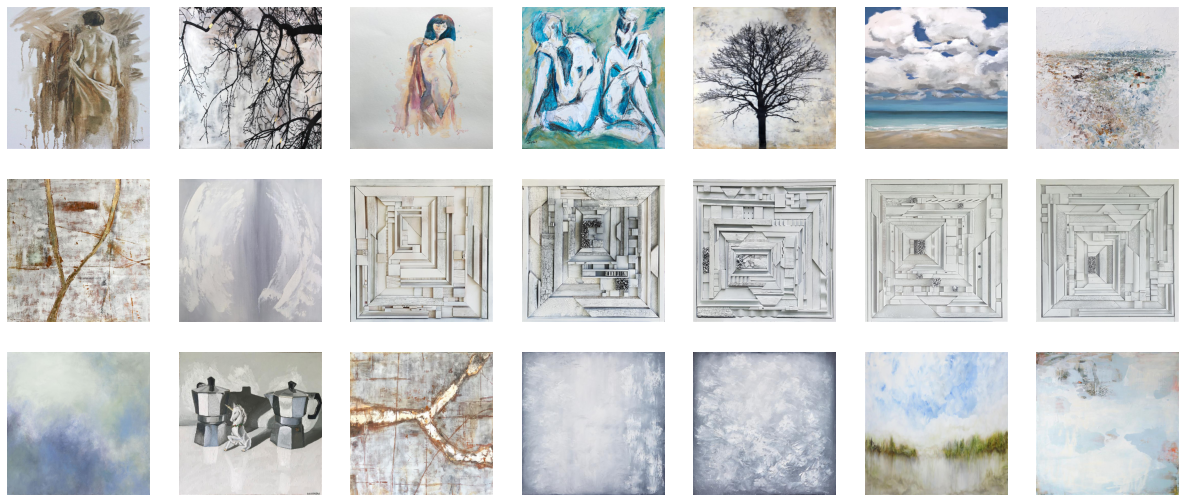

In [16]:
show_img_by_group(img_names, data_labels, 2, grid = (7, 3))

In [17]:
save_groups('HSV25/', img_names, data_labels)

In [18]:
clustering_images_v1("saves_HSV25/", "images/", "HSV25/", clu = 50) #WARNING : Too heavy works (Takes long Time)